In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Thư viện xử lý biểu thức chính quy (Regular Expressions) để làm sạch văn bản
import string

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
#Doc file
df = pd.read_csv('bbc-news-data.csv',delimiter='\t')
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [62]:
#Xem thông tin dữ liệu và các cột bị thiếu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [63]:
#Đếm số lượng bài báo của mỗi chủ đề
category_counts = df['category'].value_counts()
category_counts

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

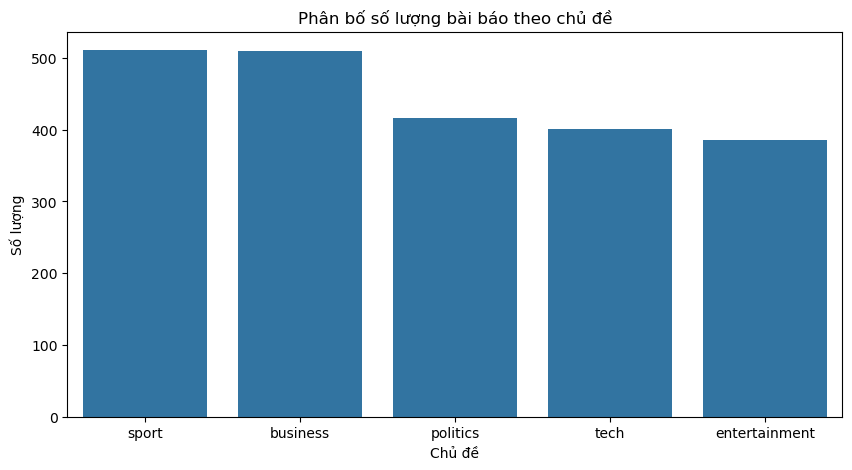

In [64]:
# Trực quan hóa bằng biểu đồ cột
plt.figure(figsize=(10,5))

sns.countplot(x='category',data = df, order=category_counts.index)
plt.title("Phân bố số lượng bài báo theo chủ đề")
plt.xlabel('Chủ đề')
plt.ylabel('Số lượng')

plt.show()

## Tiền Xử Lý và Vector Hóa Dữ Liệu

In [65]:
##Tạo cột text mới
df['text'] = df['title']+ ' ' + df['content']

##Lấy ra 2 cột target và feature :  text (X) với cột category (Y)
df2 = df[['category','text']].copy()
df2.head()

,category,text
0,business,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq Shares in U...


In [66]:
#Làm sạch văn bản
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text) # Xóa text trong ngoặc vuông
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '' , text) # Xóa dấu câu
    text = re.sub(r'\w*\d\w*', '' , text) # Xóa các từ chứa số
    text = re.sub(r'[‘’“”…]', '', text) # Xóa các dấu nháy đặc biệt
    text = re.sub(r'\n', '', text) # Xóa ký tự xuống dòng
    return text

In [67]:
#Tạo cột văn bản đã làm sạch mới
df2['text_clean'] = df2['text'].apply(clean_text)
df2.head()

,category,text,text_clean
0,business,Ad sales boost Time Warner profit Quarterly p...,ad sales boost time warner profit quarterly p...
1,business,Dollar gains on Greenspan speech The dollar h...,dollar gains on greenspan speech the dollar h...
2,business,Yukos unit buyer faces loan claim The owners ...,yukos unit buyer faces loan claim the owners ...
3,business,High fuel prices hit BA's profits British Air...,high fuel prices hit bas profits british airw...
4,business,Pernod takeover talk lifts Domecq Shares in U...,pernod takeover talk lifts domecq shares in u...


In [68]:
#Tách tập train 80%, test 20%
X = df2['text_clean']
y = df2['category']

X_train, X_test, y_train, y_test = train_test_split(X,y ,train_size = 0.8, random_state=42, stratify = y)

print(f"Kích thước tập train: {len(X_train)}")
print(f"Kích thước tập test: {len(X_test)}")

Kích thước tập train: 1780
Kích thước tập test: 445


In [69]:
#Vector hóa dữ liệu (TF-IDF) : "Dịch" Văn Bản Sang Ngôn Ngữ Toán Học

# Khởi tạo TfidfVectorizer
# Thêm stop_words='english' để loại bỏ các từ thông dụng tiếng Anh
vectorizer = TfidfVectorizer(stop_words='english')

# Fit và transform trên tập train
X_train_tfidf = vectorizer.fit_transform(X_train)

# Chỉ transform trên tập test (dùng từ điển đã học từ tập train)
X_test_tfidf = vectorizer.transform(X_test)

## Giai Đoạn 3: Huấn Luyện, So Sánh và Đánh Giá Mô Hình

In [70]:
# Tạo danh sách các mô hình
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter = 1000, random_state=42),
    "Linear SVM": LinearSVC(random_state=42),
}

In [71]:
# Lặp qua từng mô hình
for model_name, model in models.items():
    # Huấn luyện
    model.fit(X_train_tfidf,y_train)

    # Dự đoán
    y_pred = model.predict(X_test_tfidf)

    #Lưu chỉ số đánh giá các model để so sánh
    accs = []
    accs.append(accuracy_score(y_test, y_pred))
    
    # Đánh giá và in kết quả
    print(f"========== {model_name} ==========")
    print(f"Độ chính xác: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    print("\n")

print("Độ chính xác lớn nhất :", round(max(accs),4))

========== Naive Bayes ==========
Độ chính xác: 0.9888
               precision    recall  f1-score   support

     business       0.99      0.98      0.99       102
entertainment       1.00      0.99      0.99        77
     politics       0.98      0.99      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.98      0.99      0.98        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



========== Logistic Regression ==========
Độ chính xác: 0.9888
               precision    recall  f1-score   support

     business       0.99      0.97      0.98       102
entertainment       1.00      1.00      1.00        77
     politics       0.99      0.98      0.98        84
        sport       0.99      1.00      1.00       102
         tech       0.98      1.00      0.99        80

     accuracy                           0.99      

In [72]:
#Phân tích sâu hơn với Ma trận nhầm lẫn
##Ta thấy độ chính xác của Linear SVM lớn nhất => chọn Linear SVM
best_model = LinearSVC(random_state=42)
best_model.fit(X_train_tfidf,y_train)
y_pred = best_model.predict(X_test_tfidf)

In [73]:
# Lấy tên các lớp (category)
class_names = best_model.classes_
class_names

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

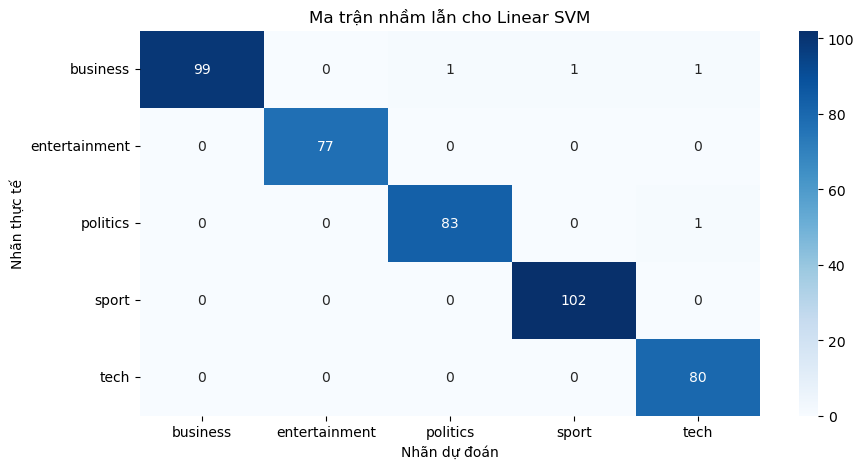

In [74]:
# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test,y_pred,labels = class_names)

plt.figure(figsize=(10,5))
sns.heatmap(cm,annot = True, fmt='d', cmap='Blues', xticklabels= class_names,yticklabels = class_names)
plt.title('Ma trận nhầm lẫn cho Linear SVM')
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.show()

In [75]:
#Hoàn Thiện và Lưu Mô Hình
import joblib

# 1. Khởi tạo lại vectorizer và mô hình tốt nhất
final_vectorizer = TfidfVectorizer(stop_words='english')
final_model = LinearSVC(random_state=42)

# 2. Fit vectorizer trên toàn bộ cột 'text_clean'
X_tfidf = final_vectorizer.fit_transform(df2['text_clean'])

# 3. Huấn luyện mô hình trên toàn bộ dữ liệu
final_model.fit(X_tfidf,df2['category'])

# 4. Lưu lại vectorizer và model để deploy
# Tạo thư mục models nếu chưa có
import os
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(final_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(final_model, 'models/news_classifier_model.pkl')

print("Đã lưu thành công vectorizer và mô hình cuối cùng vào thư mục 'models'!")

Đã lưu thành công vectorizer và mô hình cuối cùng vào thư mục 'models'!


In [86]:
# Tải lại model và vectorizer để kiểm tra
loaded_vectorizer = joblib.load('models/tfidf_vectorizer.pkl')
loaded_model = joblib.load('models/news_classifier_model.pkl')

# Viết một bài báo ví dụ
example_text = "Manchester United won the football match against Liverpool with a score of 2-0. Ronaldo scored a goal."

# Thực hiện các bước y hệt như khi deploy
cleaned_example = clean_text(example_text) #Tiền xử lí
vectorized_example = loaded_vectorizer.transform([cleaned_example]) #Vector hóa
prediction = loaded_model.predict(vectorized_example) #Dự đoán

print(f"Đoạn văn bản ví dụ:\n'{example_text}'")
print(f"\nChủ đề dự đoán là: {prediction[0]}")

Đoạn văn bản ví dụ:
'Manchester United won the football match against Liverpool with a score of 2-0. Ronaldo scored a goal.'

Chủ đề dự đoán là: sport
